In [51]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import math
#-----------------model-----------------------
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
#---------------------------------------------
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, max_error, r2_score

In [2]:
def rfecv(model, x_train, y_train):
  r = RFECV(estimator = model, step = 1, cv = 3, scoring = 'neg_mean_squared_error').fit(x_train, y_train)
  print("Optimal number of features : %d" % r.n_features_)
  print("Support : %s" % r.support_)
  print("Ranking : %s" % r.ranking_)

  return r.n_features_, r.support_

In [3]:
def grid_search(model, param_grid, x_train, y_train):
  optimal_paramas = GridSearchCV(
      model,
      param_grid,
      cv = 3,
      scoring = 'neg_mean_squared_error',
      verbose = 1,
      n_jobs = -1
  )
  optimal_paramas.fit(x_train, y_train)
  print(optimal_paramas.best_params_)

In [4]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree = degree), LinearRegression(**kwargs))

In [5]:
def randomsearchCV(model, param, x_train, y_train):
  optimal_paramas = RandomizedSearchCV(
      model,
      param,
      cv = 3,
      scoring = 'neg_mean_squared_error',
      verbose = 1,
      n_iter = 50,
      n_jobs = -1
  )
  optimal_paramas.fit(x_train, y_train)
  print(optimal_paramas.best_params_)

In [6]:
def fs_embedded(model, threshold, x_train, y_train):
  score = []
  best_threshold = 0
  best_score = 0
  for i in threshold:
    x_embedded = SelectFromModel(model, threshold = i).fit_transform(x_train, y_train)
    mean_score = cross_val_score(model, x_embedded, y_train, cv = 5).mean()
    score.append(mean_score)
    if(mean_score > best_score): 
      best_score = mean_score
      best_threshold = i
  
  print(best_threshold)
  print(best_score)
  plt.plot(threshold, score)
  plt.show()

In [7]:
def regression_model_evaluation_result(train_X,train_Y,test_X,test_Y,model):
    ''' Training Model, Evaluation, Indices
    Args:
        train_X: (pd.DataFrame) training data
        train_Y: (pd.Series) labels of training data
        test_X: (pd.DataFrame) test data
        test_Y: (pd.Series) labels of test data
        model: (scikit learn model) untrain model
    Returns:
        summary: (pd.DataFrame), 
        svr_train: (pd.DataFrame), 
        train_pred: (np.ndarray), 
        svr_test: (pd.DataFrame) , 
        test_pred: (np.ndarray), 
        model: (scikit learn model) trained model
    '''
    # Training and Prediction
    model.fit(train_X, train_Y)
    train_pred = model.predict(train_X)
    

    # Evaluation: Training
    size, var_num = train_X.shape
    train_R2 = r2_score(train_Y, train_pred)
    train_adj_R2 = 1-(1-train_R2)*(size-1)/(size-var_num-1)
    train_MAE = mean_absolute_error(train_Y, train_pred)
    train_MSE = mean_squared_error(train_Y, train_pred)
    train_RMSE = (train_MSE ** 0.5)
    train_Max_error = max_error(train_Y, train_pred)
    svr_train = pd.DataFrame(data = {"actual values":train_Y, "predicted values":train_pred})

    # Prediction: Test
    test_pred = model.predict(test_X)

    # Evaluation: Test
    test_R2 = r2_score(test_Y, test_pred)
    test_adj_R2 = 1-(1-test_R2)*(size-1)/(size-var_num-1)
    test_MAE = mean_absolute_error(test_Y, test_pred)
    test_MSE = mean_squared_error(test_Y, test_pred)
    test_RMSE = (test_MSE ** 0.5)
    test_Max_error = max_error(test_Y, test_pred)
    svr_test = pd.DataFrame(data = {"actual values":test_Y, "predicted values":test_pred})

    # Summary
    result = [{"Max error":train_Max_error, "MAE":train_MAE, "MSE":train_MSE, "RMSE":train_RMSE, "R2":train_R2, "Adjusted R2": train_adj_R2},
                {"Max error":test_Max_error, "MAE":test_MAE, "MSE":test_MSE, "RMSE":test_RMSE, "R2":test_R2, "Adjusted R2": test_adj_R2}]

    summary = pd.DataFrame(result)
    summary.index = ["Training", "Test"]
    summary.round(2)
    print(summary)

    return summary, svr_train, train_pred, svr_test, test_pred, model

In [8]:
def actual_vs_predict(tr_act, tr_pre, te_act, te_pre):
  #training
  plt.figure(figsize=(5, 5))
  plt.scatter(tr_act, tr_pre)
  plt.plot([tr_act, tr_pre],[tr_act, tr_pre], 'r-')
  plt.xlabel('actual Values ')
  plt.ylabel('Predictions value ')
  plt.axis('equal')
  plt.axis('square')
  plt.title('training')
  
  #test
  plt.figure(figsize=(5, 5))
  plt.scatter(tr_act, tr_pre)
  plt.plot([te_act, te_pre],[te_act, te_pre], 'r-')
  plt.xlabel('actual Values ')
  plt.ylabel('Predictions value ')
  plt.axis('equal')
  plt.axis('square')
  plt.title('test')

In [9]:
df = pd.read_excel('dialysisRegression.xlsx')

In [11]:
print(df)

         d1     d2      d3   d4   d5   d6    d7   d8   d9   d10  ...    c43  \
0      1.61  1.710  1250.0  1.0  1.0  1.0  40.0  5.0  2.5  1250  ...  698.9   
1      1.61  1.710  1250.0  1.0  1.0  1.0  40.0  5.0  2.5  1250  ...  698.9   
2      1.61  1.710  1250.0  1.0  1.0  1.0  40.0  5.0  2.5  1250  ...  698.9   
3      1.61  1.710  1250.0  1.0  1.0  1.0  40.0  5.0  2.5  1250  ...  698.9   
4      1.61  1.710  1250.0  1.0  1.0  1.0  40.0  5.0  2.5  1250  ...  698.9   
...     ...    ...     ...  ...  ...  ...   ...  ...  ...   ...  ...    ...   
10264  1.61  1.715     0.0  1.0  1.0  1.0  20.0  1.0  2.5  1250  ...  260.8   
10265  1.61  1.715     0.0  1.0  1.0  1.0  20.0  1.0  2.5  1250  ...  260.8   
10266  1.61  1.715     0.0  1.0  1.0  1.0  20.0  1.0  2.5  1250  ...  260.8   
10267  1.61  1.715     0.0  1.0  1.0  1.0  20.0  1.0  2.5  1250  ...  260.8   
10268  1.61  1.715     0.0  1.0  1.0  1.0  20.0  1.0  2.5  1250  ...  260.8   

         c44    c45   c46   c47   c48   c49    c50 

**preprocession**

In [10]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 0)

In [11]:
plt.figure(figsize=(8,60))
correlation_matrix = df.corr().loc[:,['label']]

# annot = True 讓我們可以把數字標進每個格子裡
#sns.heatmap(data=correlation_matrix, square = True, annot = True)

ori_column = df.columns
column_and_corr = pd.DataFrame([ori_column, correlation_matrix['label']]).T
column_and_corr = column_and_corr.rename(columns = {0:'features', 1:'pearson'})
print(column_and_corr)

   features   pearson
0        d1 -0.012247
1        d2 -0.012945
2        d3 -0.011087
3        d4 -0.011846
4        d5 -0.006813
..      ...       ...
86      c48 -0.003589
87      c49 -0.022903
88      c50  0.002657
89      c51   0.00629
90    label       1.0

[91 rows x 2 columns]


<Figure size 576x4320 with 0 Axes>

In [12]:
prefeature = []

for i in column_and_corr.iloc:
  if(abs(i['pearson']) >= 0.005 and abs(i['pearson']) != 1): prefeature.append(i['features'])

print(prefeature)
print(len(prefeature))

train_predata = train_df.loc[:, prefeature]
test_predata = test_df.loc[:, prefeature]

# print(train_predata)
# print(test_predata)

['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd12', 'd13', 'd14', 'd15', 'd17', 'd18', 'd20', 'd21', 'd22', 'd27', 'd28', 'd29', 'd31', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'c1', 'c2', 'c3', 'c4', 'c6', 'c7', 'c8', 'c9', 'c10', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c25', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c43', 'c44', 'c45', 'c46', 'c49', 'c51']
68


In [13]:
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

scaler_std = preprocessing.StandardScaler().fit(train_predata)
x_pretrain_std = scaler_std.transform(train_predata)
x_pretest_std = scaler_std.transform(test_predata)


In [ ]:
# print(x_pretrain_std)
# print(x_pretest_std)
# print(y_train.shape)

(7188,)


**SVR**

In [ ]:
svr = SVR(kernel = 'linear')
n_feature, selected = rfecv(svr, x_pretrain_std, y_train)

Optimal number of features : 47
Support : [False  True False False  True False  True  True False False  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True False  True  True  True  True  True  True  True False False  True
  True False  True  True  True  True  True  True False  True  True False
  True False  True  True  True False False  True  True False  True  True
  True False False  True False False  True  True]
Ranking : [22  1 21 11  1 20  1  1 14 17  1  1  1  1  1  1  1  1  1  1  3  1  1  1
  1 19  1  1  1  1  1  1  1  6 10  1  1 12  1  1  1  1  1  1  5  1  1  7
  1  4  1  1  1  9 13  1  1 18  1  1  1 15  8  1  2 16  1  1]


In [16]:
# selected = ['d2', 'd5', 'd7', 'd8', 'd13', 'd14', 'd15', 'd17', 'd18', 'd20', 'd21',
#        'd22', 'd27', 'd28', 'd31', 'd34', 'd35', 'd36', 'd38', 'd39', 'c1',
#        'c2', 'c3', 'c4', 'c6', 'c9', 'c10', 'c13', 'c14', 'c15', 'c16', 'c17',
#        'c18', 'c20', 'c21', 'c23', 'c28', 'c29', 'c30', 'c33', 'c34', 'c36',
#        'c37', 'c38', 'c44', 'c49', 'c51']

In [17]:
svr_train_data = train_predata.loc[:, selected]
svr_test_data = test_predata.loc[:, selected]

print(svr_train_data)

         d2   d5    d7   d8    d13   d14   d15  d17  d18    d20  ...  c29  \
7672  1.825  2.0  30.0  1.0  137.0  17.0  17.0    4  5.0  16.00  ...  4.1   
8109  1.700  1.0  20.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  3.7   
5561  1.870  0.0  40.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  5.4   
4617  1.690  3.0  50.0  1.0  137.0  17.0  17.0    4  5.0  17.00  ...  3.9   
3750  1.865  1.0  40.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  6.0   
...     ...  ...   ...  ...    ...   ...   ...  ...  ...    ...  ...  ...   
9225  1.675  1.0  30.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  4.7   
4859  1.720  1.0  40.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  3.3   
3264  1.780  1.0  50.0  1.0  137.0  16.0  16.0    4  5.0  16.00  ...  4.5   
9845  1.800  2.0  30.0  1.0  137.0  17.0  17.0    4  5.0  16.00  ...  4.5   
2732  1.840  2.0  20.0  1.0  137.0  17.0  17.0    4  5.0  16.35  ...  4.3   

       c30   c33   c34    c36    c37    c38    c44   c49     c51  
7672  19

In [18]:
svr_scaler_std = preprocessing.StandardScaler().fit(svr_train_data)
svr_x_train_std = svr_scaler_std.transform(svr_train_data)
svr_x_test_std = svr_scaler_std.transform(svr_test_data)

In [ ]:
param = {
    'kernel': ['rbf'],
    'C': [14, 16, 18, 20, 22],
    'gamma': [0.01, 0.1, 0.125, 0.15, 1]
}

model = SVR()
randomsearchCV(model, param, svr_x_train_std, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'kernel': 'rbf', 'gamma': 0.01, 'C': 22}


In [ ]:
param = {
    'kernel': ['rbf'],
    'C': [20, 22, 24, 25, 26],
    'gamma': [0.01, 0.015, 0.025, 0.05, 0.1]
}

model = SVR()
randomsearchCV(model, param, svr_x_train_std, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'kernel': 'rbf', 'gamma': 0.015, 'C': 26}


In [ ]:
param = {
    'kernel': ['rbf'],
    'C': range(26, 36, 2),
    'gamma': [0.015]
}

model = SVR()
randomsearchCV(model, param, svr_x_train_std, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'kernel': 'rbf', 'gamma': 0.015, 'C': 32}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   4.094848  0.251255  0.169342  0.411512  0.745184     0.743506
Test       4.724600  0.376903  0.304595  0.551901  0.561360     0.558472


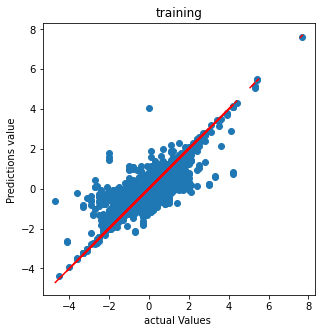

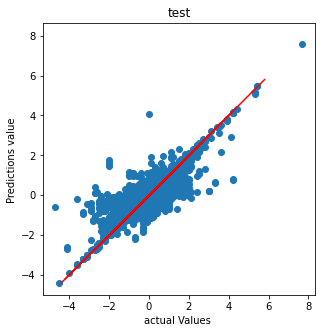

In [ ]:
svr_model=SVR(kernel = 'rbf',C = 32, gamma=0.015)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(svr_x_train_std, y_train, svr_x_test_std, y_test, svr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**ElasticNet Regression**

rfecv

In [12]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = 0.1)
elastic_cv.fit(x_pretrain_std, y_train)

print(elastic_cv.alpha_)

0.00924179159763729


In [ ]:
en = elastic_model = linear_model.ElasticNet(alpha=0.00924179159763729,l1_ratio=0.1)
n_feature, selected = rfecv(en, x_pretrain_std, y_train)

Optimal number of features : 41
Support : [ True False False False False  True False False False False  True  True
  True  True  True False  True  True False  True  True  True  True  True
 False False  True False  True False  True False  True False False  True
  True  True  True  True  True  True  True  True False  True  True False
 False False  True  True  True  True  True  True  True  True False  True
 False  True  True  True False False False False]
Ranking : [ 1  6 13 23 18  1 22  5 21 16  1  1  1  1  1  9  1  1 14  1  1  1  1  1
 28  2  1 26  1 25  1 12  1  4 27  1  1  1  1  1  1  1  1  1 11  1  1 20
  7 17  1  1  1  1  1  1  1  1  8  1  3  1  1  1 10 19 24 15]


In [ ]:
en_train_data = train_predata.loc[:, selected]
en_test_data = test_predata.loc[:, selected]

print(en_train_data.columns)
print(en_train_data)

Index(['d1', 'd6', 'd13', 'd14', 'd15', 'd17', 'd18', 'd21', 'd22', 'd28',
       'd29', 'd31', 'd34', 'd35', 'd38', 'c1', 'c3', 'c6', 'c9', 'c10', 'c12',
       'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c20', 'c21', 'c28', 'c29',
       'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c37', 'c39', 'c43', 'c44'],
      dtype='object')
         d1   d6    d13   d14   d15  d17  d18    d21  d22  d28  ...   c30  \
7672  1.740  1.0  137.0  17.0  17.0    4  5.0  16.00    2    2  ...  19.5   
8109  1.600  1.0  137.0  16.0  16.0    4  5.0  16.00    4    2  ...  13.6   
5561  1.770  0.5  137.0  16.0  16.0    4  5.0  16.00    4    2  ...  19.4   
4617  1.600  1.0  137.0  17.0  17.0    4  5.0  17.00    2    1  ...  13.3   
3750  1.760  0.5  137.0  16.0  16.0    4  5.0  16.00    2    2  ...  26.0   
...     ...  ...    ...   ...   ...  ...  ...    ...  ...  ...  ...   ...   
9225  1.600  1.0  137.0  16.0  16.0    4  5.0  16.00    4    2  ...  12.9   
4859  1.600  0.5  137.0  16.0  16.0    4  5.0  16.00

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

In [ ]:
elastic_cv = linear_model.ElasticNetCV(alphas = np.linspace(0.001, 1, 200), cv= 5, random_state = 0, l1_ratio = np.linspace(0.001, 1, 100))
elastic_cv.fit(en_x_train_std, y_train)

print(elastic_cv.alpha_)
print(elastic_cv.l1_ratio_)

0.006020100502512563
0.001


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   6.275080  0.530115  0.519546  0.720795  0.218219     0.213733
Test       4.919666  0.543145  0.542386  0.736469  0.218921     0.214440


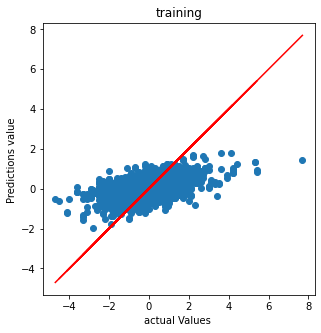

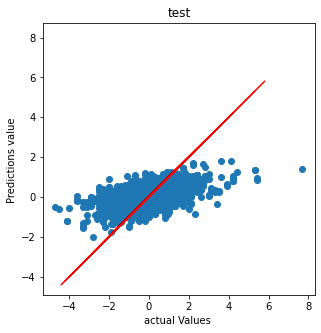

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.006020100502512563,l1_ratio=0.001)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

embedded

In [ ]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0)
elastic_cv.fit(x_pretrain_std, y_train)

print(elastic_cv.alpha_)

0.003713782536160237


In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.003713782536160237)
elastic_model.fit(x_pretrain_std, y_train)

threshold = []
for i in elastic_model.coef_:
  if(i != 0): threshold.append(i)

preselected = np.array(elastic_model.coef_[:] != 0)
en_train_predata = train_predata.loc[:, preselected]
en_test_predata = test_predata.loc[:, preselected]
threshold.sort()

print(en_train_predata)

         d1     d2      d3   d5   d6   d8    d13   d14   d15  d17  ...   c33  \
7672  1.740  1.825  1250.0  2.0  1.0  1.0  137.0  17.0  17.0    4  ...   8.6   
8109  1.600  1.700  1000.0  1.0  1.0  1.0  137.0  16.0  16.0    4  ...   9.2   
5561  1.770  1.870  1250.0  0.0  0.5  1.0  137.0  16.0  16.0    4  ...  10.7   
4617  1.600  1.690     0.0  3.0  1.0  1.0  137.0  17.0  17.0    4  ...   9.7   
3750  1.760  1.865  1000.0  1.0  0.5  1.0  137.0  16.0  16.0    4  ...   8.5   
...     ...    ...     ...  ...  ...  ...    ...   ...   ...  ...  ...   ...   
9225  1.600  1.675  1250.0  1.0  1.0  1.0  137.0  16.0  16.0    4  ...  10.1   
4859  1.600  1.720   250.0  1.0  0.5  1.0  137.0  16.0  16.0    4  ...   9.4   
3264  1.680  1.780  1250.0  1.0  1.0  1.0  137.0  16.0  16.0    4  ...   8.4   
9845  1.600  1.800  1000.0  2.0  1.0  1.0  137.0  17.0  17.0    4  ...   9.8   
2732  1.735  1.840  1250.0  2.0  1.0  1.0  137.0  17.0  17.0    4  ...   9.9   

       c34      c35    c36    c37    c3

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_predata)
en_x_pretrain_std = en_scaler_std.transform(en_train_predata)
en_x_pretest_std = en_scaler_std.transform(en_test_predata)

print(en_x_pretrain_std.shape)

(7188, 54)


0.012663678039826843
0.20527094606474652


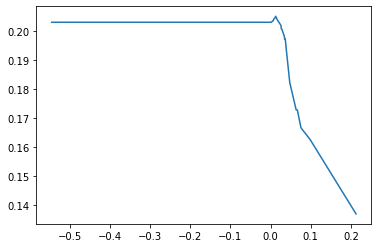

In [ ]:
fs_embedded(elastic_model, threshold, en_x_pretrain_std, y_train)

In [ ]:
selected = np.array(elastic_model.coef_[:] >= 0.012663678039826843)

# print(preselected)
# print(selected)

en_train_data = train_predata.loc[:, selected]
en_test_data = test_predata.loc[:, selected]

print(en_train_data)
print(en_train_data.columns)

en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

        d13  d18  d22  d28  d31  d35  d38   c3     c9   c10  c13   c17   c20  \
7672  137.0  5.0    2    2  5.0    1  1.0  2.3  160.0  65.0   30   0.0  33.7   
8109  137.0  5.0    4    2  5.0    1  1.0  3.4  154.0  51.7   21   0.0  32.5   
5561  137.0  5.0    4    2  5.0    1  1.0  2.5  168.0  68.0   10   0.0  33.9   
4617  137.0  5.0    2    1  5.0    1  1.0  1.5  165.0  64.0   19  10.0  33.0   
3750  137.0  5.0    2    2  5.0    1  1.0  3.0  169.0  59.1   10   0.0  32.2   
...     ...  ...  ...  ...  ...  ...  ...  ...    ...   ...  ...   ...   ...   
9225  137.0  5.0    4    2  5.0    1  1.0  3.0  154.0  46.6   10  25.0  34.5   
4859  137.0  5.0    2    2  5.0    1  1.0  1.2  154.0  51.5   10   0.0  36.1   
3264  137.0  5.0    3    2  5.0    1  1.0  3.0  160.0  56.3   30   0.0  33.0   
9845  137.0  5.0    5    2  3.0    3  3.0  2.8  165.0  59.6   10  20.0  35.4   
2732  137.0  5.0    4    2  5.0    1  1.0  1.8  165.0  63.4   10   0.0  35.9   

        c21  c31      c35    c37     c4

In [ ]:
l1_ratio = np.linspace(0.001, 1, 200)
best_score = 0
op_al = 0
op_l1 = 0

for j in l1_ratio:
  elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = j)
  elastic_cv.fit(en_x_train_std, y_train)

  if(elastic_cv.score(en_x_train_std, y_train) > best_score):
    op_al = elastic_cv.alpha_
    op_l1 = j
    best_score = elastic_cv.score(en_x_train_std, y_train)

# print(elastic_cv.alpha_)
# print(elastic_cv.l1_ratio_)
print(op_al)
print(op_l1)

0.056382243314452726
0.006020100502512563


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   6.971826  0.575437  0.625859  0.791113  0.058245     0.055880
Test       5.247022  0.583615  0.648949  0.805574  0.065462     0.063116


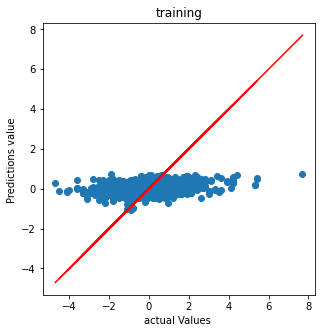

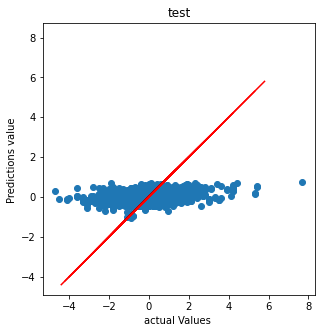

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.056382243314452726,l1_ratio=0.006020100502512563)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

用原數據

In [ ]:
X_train = train_df.iloc[:,0:-1]
X_test = test_df.iloc[:,0:-1]

scaler_Std = preprocessing.StandardScaler().fit(X_train)
X_train_Std = scaler_Std.transform(X_train)
X_test_Std = scaler_Std.transform(X_test)

In [ ]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0)
elastic_cv.fit(X_train_Std, y_train)

print(elastic_cv.alpha_)

0.0018483583195274581


In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.0018483583195274581)
elastic_model.fit(X_train_Std, y_train)

threshold = []
for i in elastic_model.coef_:
  if(i != 0): threshold.append(i)

preselected = np.array(elastic_model.coef_[:] != 0)
en_train_predata = X_train.loc[:, preselected]
en_test_predata = X_test.loc[:, preselected]
threshold.sort()

print(en_train_predata)

         d1     d2      d3   d4   d5   d6    d7   d8   d9    d11  ...  c40  \
7672  1.740  1.825  1250.0  0.0  2.0  1.0  30.0  1.0  3.5    0.0  ...  9.9   
8109  1.600  1.700  1000.0  1.0  1.0  1.0  20.0  1.0  2.5  500.0  ...  6.1   
5561  1.770  1.870  1250.0  1.0  0.0  0.5  40.0  1.0  2.5    0.0  ...  6.4   
4617  1.600  1.690     0.0  0.0  3.0  1.0  50.0  1.0  3.0    0.0  ...  5.9   
3750  1.760  1.865  1000.0  1.0  1.0  0.5  40.0  1.0  3.0  250.0  ...  7.1   
...     ...    ...     ...  ...  ...  ...   ...  ...  ...    ...  ...  ...   
9225  1.600  1.675  1250.0  2.0  1.0  1.0  30.0  1.0  2.5    0.0  ...  6.0   
4859  1.600  1.720   250.0  1.0  1.0  0.5  40.0  1.0  3.0  250.0  ...  7.5   
3264  1.680  1.780  1250.0  0.0  1.0  1.0  50.0  1.0  3.5    0.0  ...  2.6   
9845  1.600  1.800  1000.0  1.0  2.0  1.0  30.0  1.0  2.5  500.0  ...  4.8   
2732  1.735  1.840  1250.0  2.0  2.0  1.0  20.0  1.0  2.5  750.0  ...  7.5   

        c41     c43    c44    c45   c46   c47   c49    c50     

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_predata)
en_x_pretrain_std = en_scaler_std.transform(en_train_predata)
en_x_pretest_std = en_scaler_std.transform(en_test_predata)

print(en_x_pretrain_std)

[[ 1.74562542  1.47624685  1.03377891 ...  0.19776482  0.89761937
   0.11710674]
 [-0.71116987 -0.52424753  0.51937096 ... -0.65999492  0.28372948
   2.39812738]
 [ 2.27208155  2.19642483  1.03377891 ...  0.36355031 -4.27659545
  -0.13918771]
 ...
 [ 0.69271315  0.75606887  1.03377891 ... -0.28517554  0.28372948
   0.34777175]
 [-0.71116987  1.07614797  0.51937096 ... -0.11218198  0.28372948
   0.11710674]
 [ 1.65788273  1.71630618  1.03377891 ... -0.27075941  0.28372948
   1.48828207]]


0.017962027494725835
0.2199295314466923


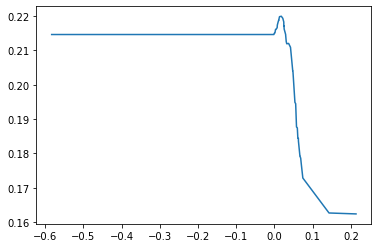

In [ ]:
fs_embedded(elastic_model, threshold, en_x_pretrain_std, y_train)

In [ ]:
selected = np.array(elastic_model.coef_[:] >= 0.017962027494725835)
en_train_data = X_train.loc[:, selected]
en_test_data = X_test.loc[:, selected]

en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

print(en_train_data.columns)

Index(['d7', 'd9', 'd11', 'd13', 'd18', 'd22', 'd23', 'd24', 'd28', 'd29',
       'd32', 'd33', 'd35', 'd37', 'd38', 'c3', 'c10', 'c14', 'c17', 'c20',
       'c21', 'c22', 'c27', 'c31', 'c35', 'c37', 'c41', 'c43', 'c50'],
      dtype='object')


In [ ]:
l1_ratio = np.linspace(0.0001, 1, 200)
best_R2 = 0
alpha = 0
best_l1_ratio = 0

for i in l1_ratio:
  elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = i)
  elastic_cv.fit(en_x_train_std, y_train)

  if(elastic_cv.score(en_x_train_std, y_train) > best_R2):
    alpha = elastic_cv.alpha_
    best_l1_ratio = i
    best_R2 = elastic_cv.score(en_x_train_std, y_train)

print(alpha)
print(best_l1_ratio)

0.05760737700131587
0.00512462311557789


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   6.951352  0.573209  0.620954  0.788006  0.065627     0.061841
Test       5.171857  0.585134  0.651122  0.806921  0.062333     0.058534


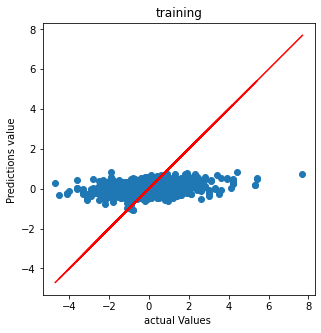

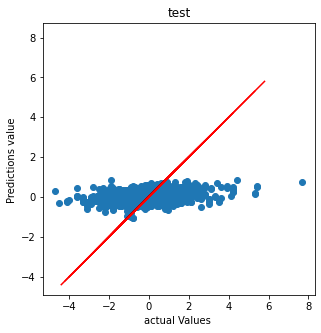

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.05760737700131587,l1_ratio=0.00512462311557789)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**Linear Regression**

In [26]:
lr = LinearRegression()
n_feature, selected = rfecv(lr, x_pretrain_std, y_train)

Optimal number of features : 45
Support : [ True False False False False False False  True False False  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False False  True
  True  True  True  True  True  True  True  True False  True  True False
 False False  True  True False  True  True  True  True False False  True
  True False  True  True False False  True False]
Ranking : [ 1  5 13 17 23  2 20  1 18 12  1  1  1  1  1 15  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 14  1  6 19  1  1  1  1  1  1  1  1  1 16  1  1 22
 11 24  1  1  9  1  1  1  1  7 10  1  1  4  1  1  8 21  1  3]


In [29]:
lr_train_data = train_predata.loc[:, selected]
lr_test_data = test_predata.loc[:, selected]

In [30]:
lr_scaler_std = preprocessing.StandardScaler().fit(lr_train_data)
lr_x_train_std = lr_scaler_std.transform(lr_train_data)
lr_x_test_std = lr_scaler_std.transform(lr_test_data)

In [32]:
param = {
    'fit_intercept': ['True', 'False']
}

model = LinearRegression()
grid_search(model, param, lr_x_train_std, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'fit_intercept': 'True'}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   6.202603  0.530613  0.521481  0.722136  0.215307     0.210363
Test       4.929116  0.544234  0.545206  0.738381  0.214860     0.209913


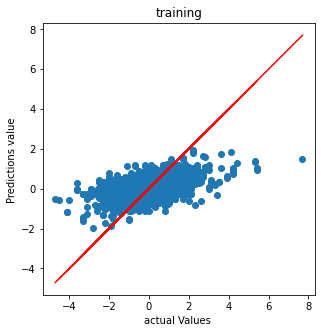

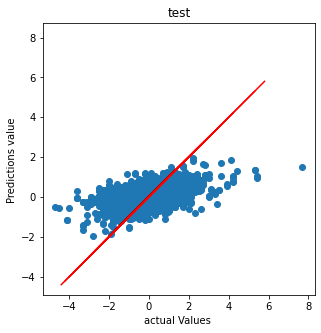

In [49]:
lr_model=LinearRegression(fit_intercept = True)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(lr_x_train_std, y_train, lr_x_test_std, y_test, lr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**XGBoost Regressor**

In [17]:
xgbr = XGBRegressor(objective='reg:squarederror')
n_feature, selected = rfecv(xgbr, x_pretrain_std, y_train)

Optimal number of features : 49
Support : [ True  True False  True False  True  True  True  True False  True  True
 False False False False False  True False  True  True  True  True False
 False False False False  True  True  True  True  True False False  True
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True]
Ranking : [ 1  1  6  1  5  1  1  1  1  9  1  1 14 16 18 17  2  1 11  1  1  1  1  7
  3  8  4 12  1  1  1  1  1 20 19  1  1  1  1 15 13  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1]


In [18]:
xgb_train_data = train_predata.loc[:, selected]
xgb_test_data = test_predata.loc[:, selected]

In [25]:
# print(xgb_train_data.columns)

Index(['d1', 'd2', 'd4', 'd6', 'd7', 'd8', 'd9', 'd13', 'd14', 'd22', 'd28',
       'd29', 'd31', 'd34', 'c1', 'c2', 'c3', 'c4', 'c6', 'c9', 'c10', 'c12',
       'c13', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c25',
       'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37',
       'c38', 'c39', 'c43', 'c44', 'c45', 'c46', 'c51'],
      dtype='object')


In [20]:
xgb_scaler_std = preprocessing.StandardScaler().fit(xgb_train_data)
xgb_x_train_std = xgb_scaler_std.transform(xgb_train_data)
xgb_x_test_std = xgb_scaler_std.transform(xgb_test_data)

In [22]:
param = {
    'eta':np.linspace(0.01, 0.2, 10),
    'gamma':np.linspace(0.001, 30, 40),
    'max_depth':range(3, 11)
}

xgbr = XGBRegressor(objective='reg:squarederror')
randomsearchCV(xgbr, param, xgb_x_train_std, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'max_depth': 9, 'gamma': 0.7702051282051282, 'eta': 0.01}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   1.868687  0.229118  0.088433  0.297377  0.866931     0.866018
Test       6.378789  0.343489  0.243542  0.493500  0.649280     0.646873


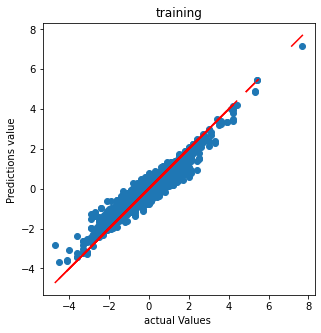

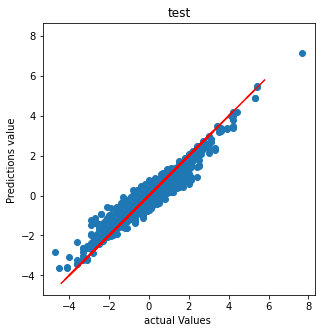

In [24]:
xgbr_model=XGBRegressor(max_depth = 9, gamma = 0.7702051282051282, eta = 0.01, objective='reg:squarederror')
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(xgb_x_train_std, y_train, xgb_x_test_std, y_test, xgbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**GradientBoostingRegressor**

In [47]:
gbr = GradientBoostingRegressor()
n_feature, selected = rfecv(gbr, x_pretrain_std, y_train)

Optimal number of features : 25
Support : [False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False  True  True  True False  True False False False
 False False False False False  True False  True  True  True  True  True
 False  True False False  True  True  True  True  True  True False  True
 False  True  True  True  True  True  True False]
Ranking : [10 22 32  3 18 17 26 31 16 30  2 13 40 44 41 36 29  1 25 27 23 33 34 37
 38 19 43 42  1  1  1 14  1 28 24 21  6 20  5 35 39  1  9  1  1  1  1  1
 11  1 12  8  1  1  1  1  1  1  4  1  7  1  1  1  1  1  1 15]


In [48]:
gbr_train_data = train_predata.loc[:, selected]
gbr_test_data = test_predata.loc[:, selected]

In [55]:
# print(gbr_train_data.columns)

Index(['d22', 'c1', 'c2', 'c3', 'c6', 'c16', 'c18', 'c19', 'c20', 'c21', 'c22',
       'c25', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c37', 'c39', 'c43',
       'c44', 'c45', 'c46', 'c49'],
      dtype='object')


In [50]:
gbr_scaler_std = preprocessing.StandardScaler().fit(gbr_train_data)
gbr_x_train_std = gbr_scaler_std.transform(gbr_train_data)
gbr_x_test_std = gbr_scaler_std.transform(gbr_test_data)

In [53]:
param = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate':np.linspace(0.01, 2, 10),
    'n_estimators': range(1, 100, 10)
}

gbr = GradientBoostingRegressor()
randomsearchCV(gbr, param, xgb_x_train_std, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 71, 'loss': 'huber', 'learning_rate': 0.45222222222222225}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   4.426517  0.378671  0.282507  0.531514  0.574901     0.573417
Test       4.768897  0.433931  0.367432  0.606162  0.470869     0.469022


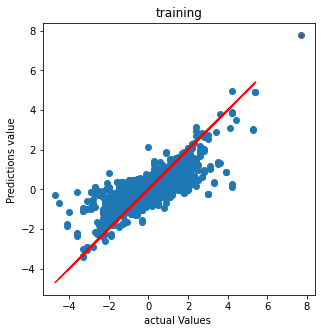

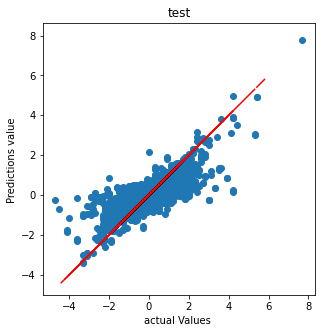

In [54]:
gbr_model=GradientBoostingRegressor(n_estimators = 71, loss = 'huber', learning_rate = 0.45222222222222225)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(gbr_x_train_std, y_train, gbr_x_test_std, y_test, gbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

In [56]:
from joblib import dump, load

In [59]:
dump(xgbr_model, 'regression.joblib')

['regression.joblib']

In [60]:
test_model = load('regression.joblib')

存特徵

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
xgb_train_data.to_csv('/content/drive/MyDrive/features_regression.csv')